This script plots the polynomial feature heatmaps presented in fig 5a

In [10]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import os
from functools import reduce
from tqdm import tqdm

read gene selection results, keep the significant genes

In [2]:
import pickle

with open('/ocean/projects/hmcmutc/qsong/projects/lung_aging/results/gene_selection_ranking/all_selected_ranked_hlca_nonsmoker.pickle', 'rb') as handle:
    ranking_all = pickle.load(handle)
with open('/ocean/projects/hmcmutc/qsong/projects/lung_aging/results/gene_selection_ranking/all_selected_ranked_hlca_nonsmoker_union_only.pickle', 'rb') as handle:
    ranking_union = pickle.load(handle)

Read data objects

In [3]:
hlca_nonsmoker = sc.read_h5ad("data/step1_HLCA_nonsmoker_processed.h5ad")

/jet/home/qsong/.conda/envs/lung_aging/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Extract data. Convert anndata to expression matrix

In [4]:
'''
Filter anndata by cell type, marker genes, and subjects. Subjects are selected by min_cells
Return filtered expression matrix and ages.
'''
def filter_anndata_single_ct(anndata, ct_column, ct, donor_column, age_column, marker_genes = None, min_cells = 20):
        
    # Keep rows annotated with current cell type, and columns annotated with marker genes,  
    ct_anndata = anndata[anndata.obs[ct_column] == ct, :]
    ct_anndata = ct_anndata[:, ct_anndata.var_names.isin(marker_genes)]
    
    # Select subjects having number of cells greater than min_cells 
    subjects = ct_anndata.obs[donor_column]
    subjects_count = subjects.groupby(subjects.values).count()
    selected_subjects = subjects_count.loc[subjects_count >= min_cells].index 
    
    # Further subset anndata using the selected subjects
    ct_anndata = ct_anndata[ct_anndata.obs[donor_column].isin(selected_subjects),]
    
    # Generate filtered expression matrix and ages
    expr = ct_anndata.to_df()
    expr.index = ct_anndata.obs[donor_column].values
    ages = ct_anndata.obs[age_column]
    ages.index = expr.index
        
    return expr, ages

Extract data for the top cell types

In [5]:
import warnings
warnings.filterwarnings("ignore")

iterator = []

for ct,annlevel in zip(["Basal","Basal resting", "Suprabasal"],['ann_level_3','ann_level_4','ann_level_4']):
    expr, ages = filter_anndata_single_ct(hlca_nonsmoker,
                                 ct_column = annlevel,
                                 ct = ct,
                                 donor_column = "donor_id",
                                 age_column = "age",
                                 marker_genes = hlca_nonsmoker.var_names,
                                 min_cells = 50
                                )
    iterator.append([
                        expr,
                        ages,
                        ct
                    ]
                   )

Extract polynomial features

In [6]:
def compute_features(expr, ages, mean_degree, var_degree, n_components, use_pca, pca_model):

    if use_pca and pca_model is None:
        pca_model = PCA(n_components=n_components, whiten=True)
        expr = pd.DataFrame(pca_model.fit_transform(expr), index = expr.index)
        expr.columns = [f"PC{i+1}" for i in range(expr.shape[1])]
    elif use_pca and pca_model is not None:
        expr = pd.DataFrame(pca_model.transform(expr), index = expr.index)
        expr.columns = [f"PC{i+1}" for i in range(expr.shape[1])]
        
    # Get each subject/individual's mean expression and polynomials of mean expressions.
    subjects = expr.index.to_list()
    expr_mean = expr.groupby(subjects).mean()
    expr_mean_poly = np.hstack([expr_mean**i for i in range(1, mean_degree+1)])
    feature_names = np.hstack([[f"{col}_mean^{deg}" for col in expr.columns] for deg in range(1,mean_degree+1)]) # Name the polynomial features
    expr_mean_poly = pd.DataFrame(
                        expr_mean_poly,
                        index = expr_mean.index,
                        columns = feature_names 
                    )
    
    if var_degree > 0:

        # Get each subject/indivisual's variances.
        expr_var = expr.groupby(subjects).var()
        expr_var.fillna(value=0,inplace=True) # This should not happen 
        expr_var_poly = np.hstack([expr_var**i for i in range(1, var_degree+1)])
        feature_names = np.hstack([[f"{col}_var^{deg}" for col in expr.columns] for deg in range(1,var_degree+1)]) # Name the polynomial features
        expr_var_poly = pd.DataFrame(
                        expr_var_poly,
                        index = expr_var.index,
                        columns = feature_names 
                    )

        # Concatenate mean and var polynomial features
        X = pd.concat([expr_mean_poly,expr_var_poly],axis = 1)
    else:
        X = expr_mean_poly
    
    # Get Y
    Y = ages.groupby(subjects).mean()
    
    return X,Y,pca_model

Plots for PMAIP1

In [7]:
from collections import defaultdict
plot_data = dict()

rows = ["$mean^1$","$mean^2$","$var^1$","$var^2$"]
for i,(expr,ages,ct) in enumerate(iterator):
    
    genes = ["PMAIP1"]
    expr = expr.loc[:,genes]
    mat,age,_ = compute_features(expr, ages, mean_degree=2, var_degree=2, n_components=10, use_pca = False, pca_model=None)
    mat = mat.transpose()
    mat.index = rows
    mat.columns = age
    order = np.argsort(age)
    mat = mat.iloc[:,order]
    mat.columns = mat.columns.astype(int)
    plot_data[ct] = mat

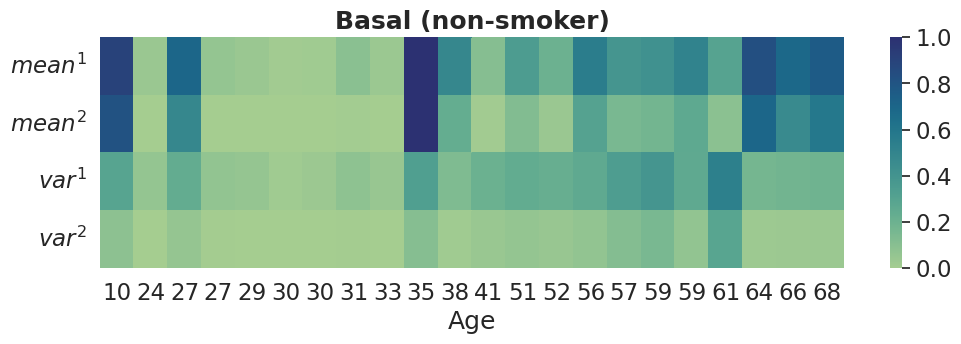

In [19]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(font_scale = 1.5)
fig,ax = plt.subplots(figsize = (12,3))
sns.heatmap(plot_data["Basal"], ax=ax, vmin=0, vmax=1, cmap="crest")
ax.set_title("Basal (non-smoker)", fontdict={"weight":"bold"})
ax.set_xlabel("Age")

if not os.path.isdir("results/figs"):
    os.mkdir("results/figs")
fig.savefig("results/figs/polyHeatmap_fig5a1.svg")

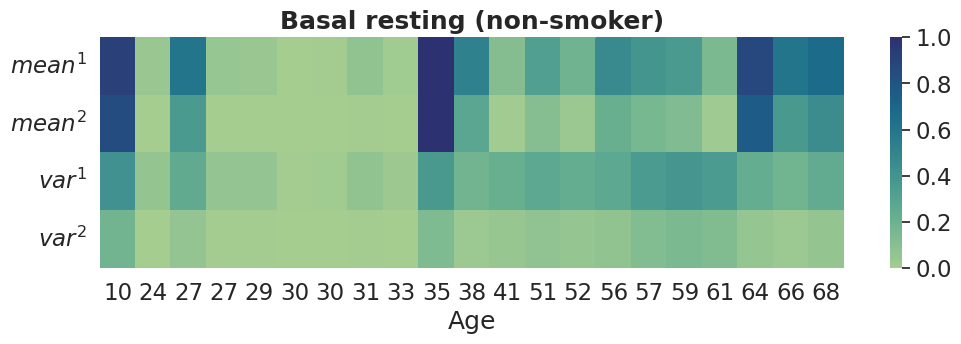

In [20]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(font_scale = 1.5)
fig,ax = plt.subplots(figsize = (12,3))
sns.heatmap(plot_data["Basal resting"], ax=ax, vmin=0, vmax=1, cmap="crest")
ax.set_title("Basal resting (non-smoker)", fontdict={"weight":"bold"})
ax.set_xlabel("Age")

if not os.path.isdir("results/figs"):
    os.mkdir("results/figs")
fig.savefig("results/figs/polyHeatmap_fig5a2.svg")

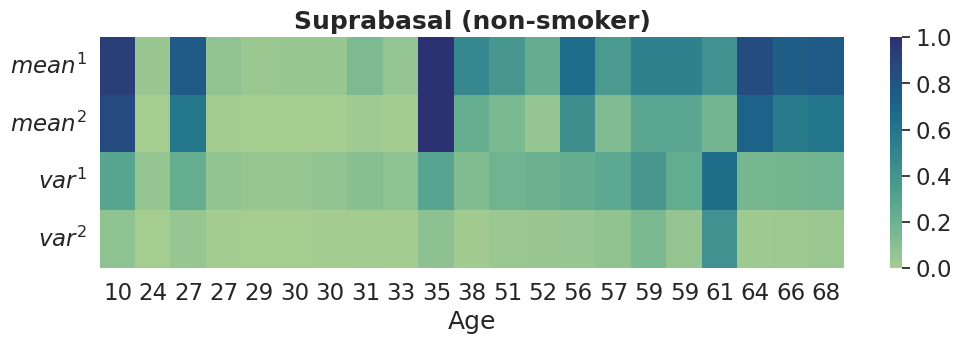

In [21]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(font_scale = 1.5)
fig,ax = plt.subplots(figsize = (12,3))
sns.heatmap(plot_data["Suprabasal"], ax=ax, vmin=0, vmax=1, cmap="crest")
ax.set_title("Suprabasal (non-smoker)", fontdict={"weight":"bold"})
ax.set_xlabel("Age")

if not os.path.isdir("results/figs"):
    os.mkdir("results/figs")
fig.savefig("results/figs/polyHeatmap_fig5a3.svg")

Plots for RHOB

In [22]:
from collections import defaultdict
plot_data = dict()

rows = ["$mean^1$","$mean^2$","$var^1$","$var^2$"]
for i,(expr,ages,ct) in enumerate(iterator):
    
    genes = ["RHOB"]
    expr = expr.loc[:,genes]
    mat,age,_ = compute_features(expr, ages, mean_degree=2, var_degree=2, n_components=10, use_pca = False, pca_model=None)
    mat = mat.transpose()
    mat.index = rows
    mat.columns = age
    order = np.argsort(age)
    mat = mat.iloc[:,order]
    mat.columns = mat.columns.astype(int)
    plot_data[ct] = mat

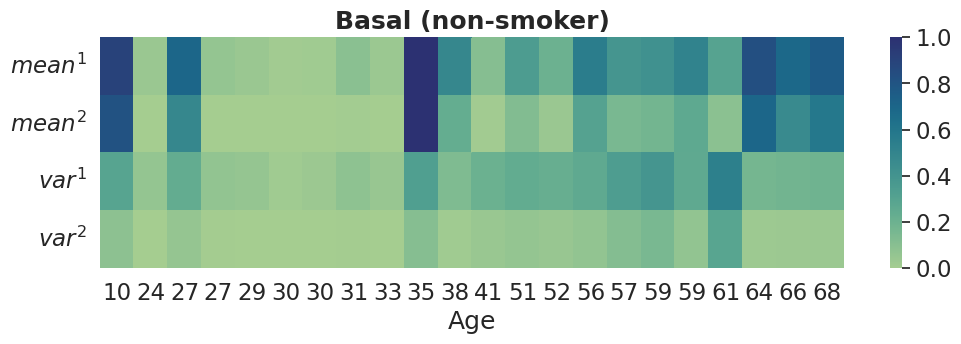

In [23]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(font_scale = 1.5)
fig,ax = plt.subplots(figsize = (12,3))
sns.heatmap(plot_data["Basal"], ax=ax, vmin=0, vmax=1, cmap="crest")
ax.set_title("Basal (non-smoker)", fontdict={"weight":"bold"})
ax.set_xlabel("Age")

if not os.path.isdir("results/figs"):
    os.mkdir("results/figs")
fig.savefig("results/figs/polyHeatmap_fig5a4.svg")

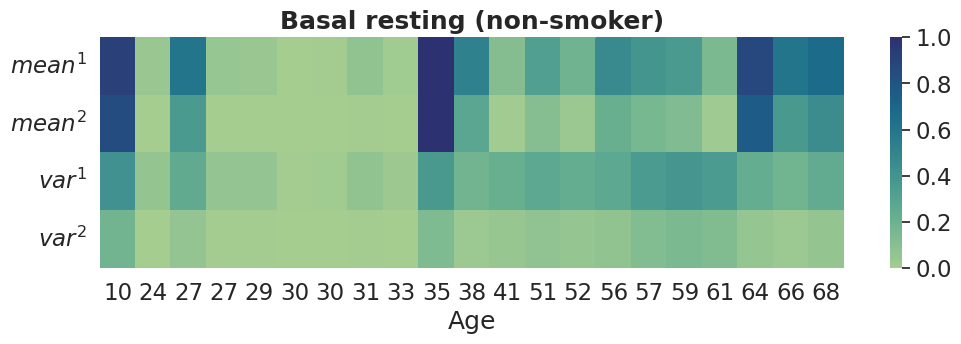

In [24]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(font_scale = 1.5)
fig,ax = plt.subplots(figsize = (12,3))
sns.heatmap(plot_data["Basal resting"], ax=ax, vmin=0, vmax=1, cmap="crest")
ax.set_title("Basal resting (non-smoker)", fontdict={"weight":"bold"})
ax.set_xlabel("Age")

if not os.path.isdir("results/figs"):
    os.mkdir("results/figs")
fig.savefig("results/figs/polyHeatmap_fig5a5.svg")

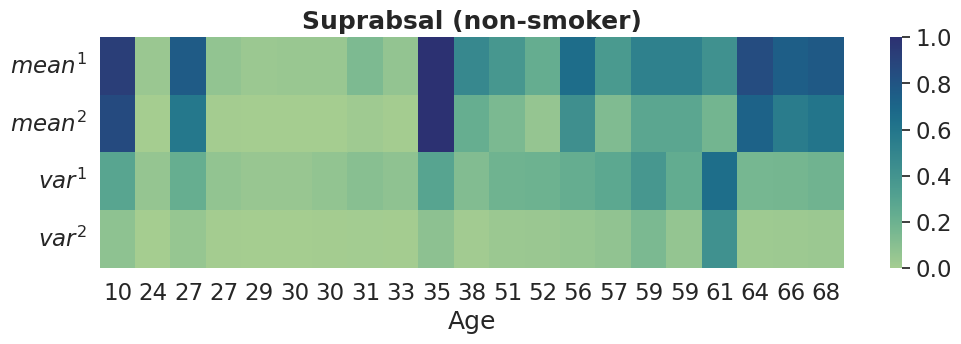

In [25]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(font_scale = 1.5)
fig,ax = plt.subplots(figsize = (12,3))
sns.heatmap(plot_data["Suprabasal"], ax=ax, vmin=0, vmax=1, cmap="crest")
ax.set_title("Suprabsal (non-smoker)", fontdict={"weight":"bold"})
ax.set_xlabel("Age")

if not os.path.isdir("results/figs"):
    os.mkdir("results/figs")
fig.savefig("results/figs/polyHeatmap_fig5a6.svg")

**Plots for all**

In [26]:
from collections import defaultdict
plot_data_all = dict()

for i,(expr,ages,ct1) in enumerate(iterator):
    for ct_column,group,ct2,gene_type,use_pca,nz_idx,gene_names,feature_names,pca_model,donor_num,scores,pvals in ranking_all:
        if ct2 == ct1:
            genes = genes = pvals[pvals <= 0.05].index.tolist()
            expr = expr.loc[:,genes]
            mat,age,_ = compute_features(expr, ages, mean_degree=2, var_degree=2, n_components=10, use_pca = False, pca_model=None)
            mat = mat.transpose()
            #mat.index = rows
            mat.columns = age
            order = np.argsort(age)
            mat = mat.iloc[:,order]
            mat.columns = mat.columns.astype(int)
            mat.iloc[np.argsort(mat.sum(axis = 1))[::-1],] # Sort row order by sum values
            plot_data_all[ct1] = mat

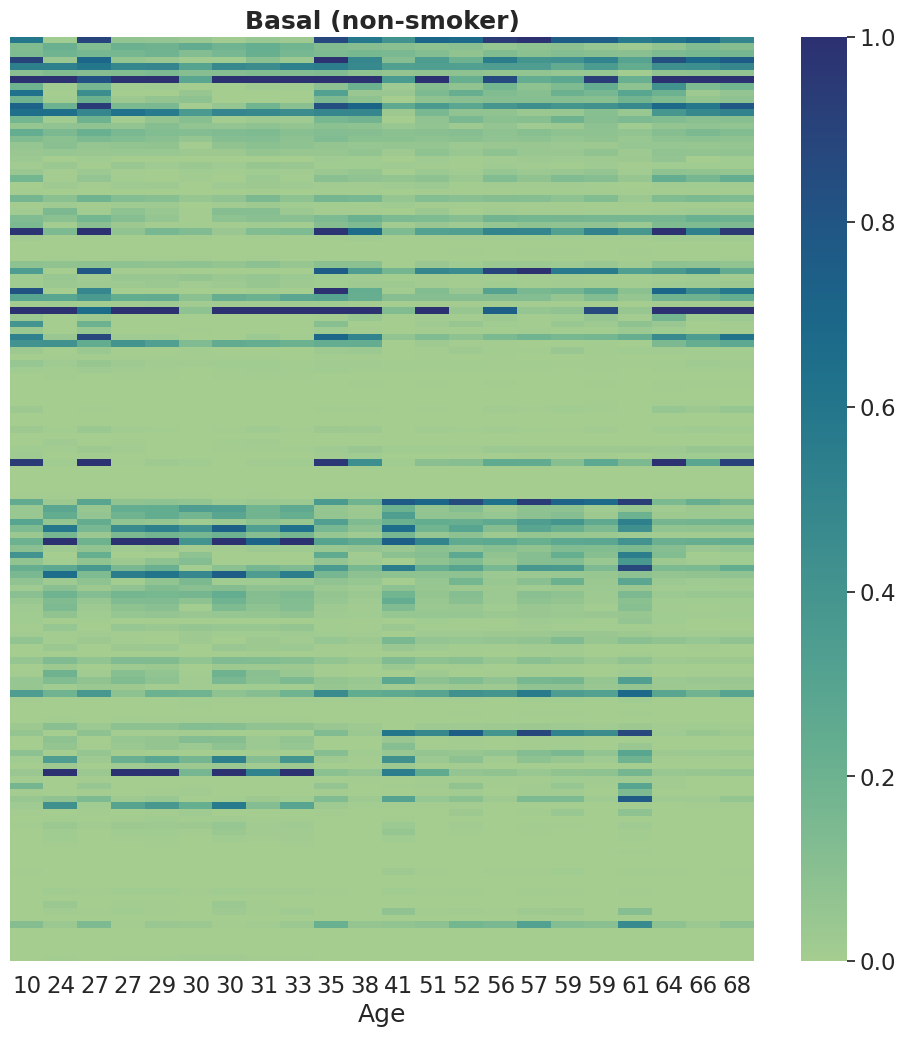

In [27]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(font_scale = 1.5)
fig,ax = plt.subplots(figsize = (12,12))
sns.heatmap(plot_data_all["Basal"], ax=ax, vmin=0, vmax=1, cmap="crest", yticklabels = False)
ax.set_title("Basal (non-smoker)", fontdict={"weight":"bold"})
ax.set_xlabel("Age")

if not os.path.isdir("results/figs"):
    os.mkdir("results/figs")
fig.savefig("results/figs/polyHeatmap_figs5_1.svg")

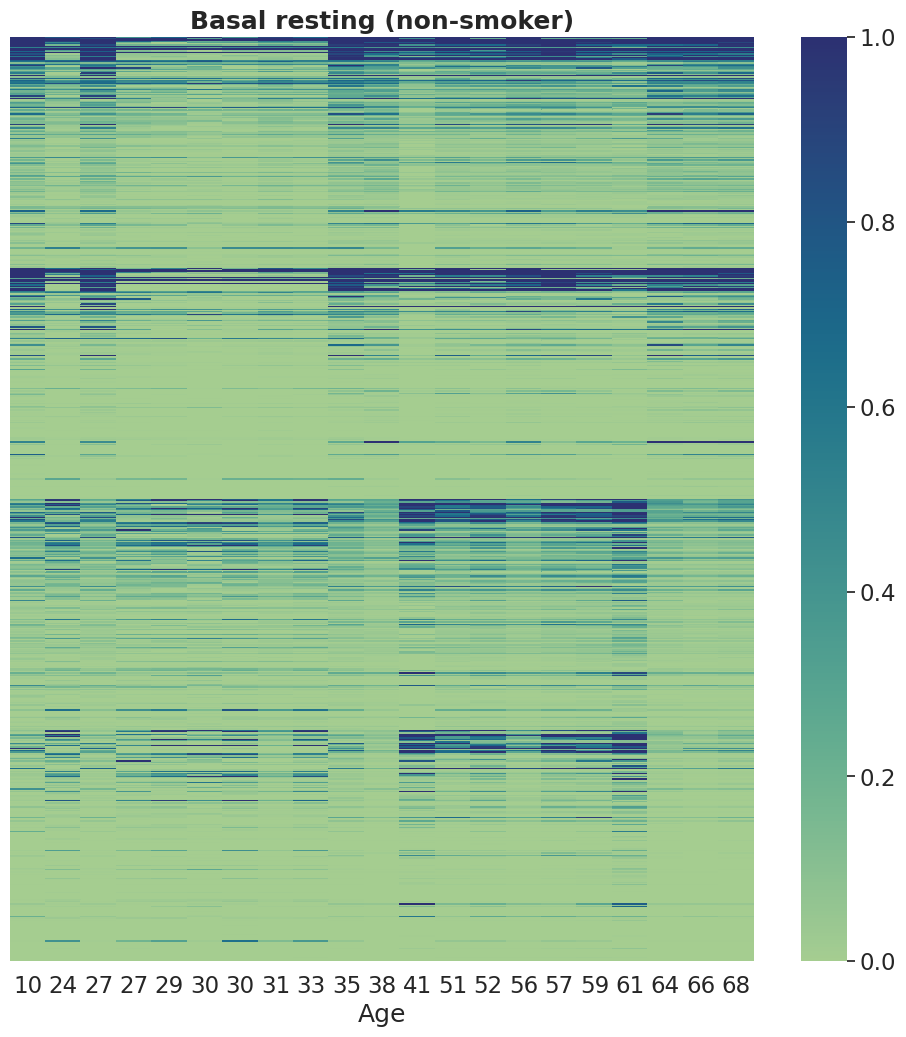

In [28]:
sns.set(font_scale = 1.5)
fig,ax = plt.subplots(figsize = (12,12))
sns.heatmap(plot_data_all["Basal resting"], ax=ax, vmin=0, vmax=1, cmap="crest", yticklabels = False)
ax.set_title("Basal resting (non-smoker)", fontdict={"weight":"bold"})
ax.set_xlabel("Age")

if not os.path.isdir("results/figs"):
    os.mkdir("results/figs")
fig.savefig("results/figs/polyHeatmap_figs5_2.svg")

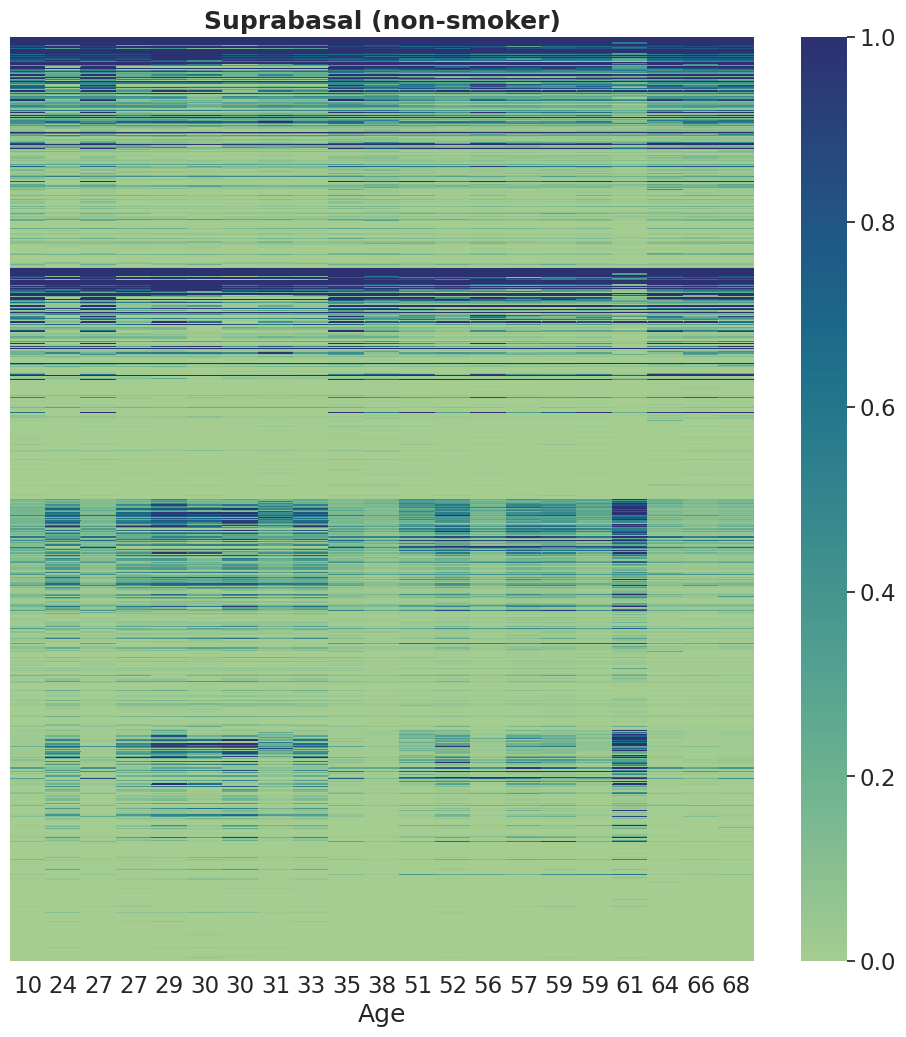

In [29]:
sns.set(font_scale = 1.5)
fig,ax = plt.subplots(figsize = (12,12))
sns.heatmap(plot_data_all["Suprabasal"], ax=ax, vmin=0, vmax=1, cmap="crest", yticklabels = False)
ax.set_title("Suprabasal (non-smoker)", fontdict={"weight":"bold"})
ax.set_xlabel("Age")

if not os.path.isdir("results/figs"):
    os.mkdir("results/figs")
fig.savefig("results/figs/polyHeatmap_figs5_3.svg")

**Plots for union**

In [30]:
from collections import defaultdict
plot_data_union = dict()

for i,(expr,ages,ct1) in enumerate(iterator):
    for ct_column,group,ct2,gene_type,use_pca,nz_idx,gene_names,feature_names,pca_model,donor_num,scores,pvals in ranking_union:
        if ct2 == ct1:
            genes = genes = pvals[pvals <= 0.05].index.tolist()
            expr = expr.loc[:,genes]
            mat,age,_ = compute_features(expr, ages, mean_degree=2, var_degree=2, n_components=10, use_pca = False, pca_model=None)
            mat = mat.transpose()
            #mat.index = rows
            mat.columns = age
            order = np.argsort(age)
            mat = mat.iloc[:,order]
            mat.columns = mat.columns.astype(int)
            mat.iloc[np.argsort(mat.sum(axis = 1))[::-1],] # Sort row order by sum values
            plot_data_union[ct1] = mat

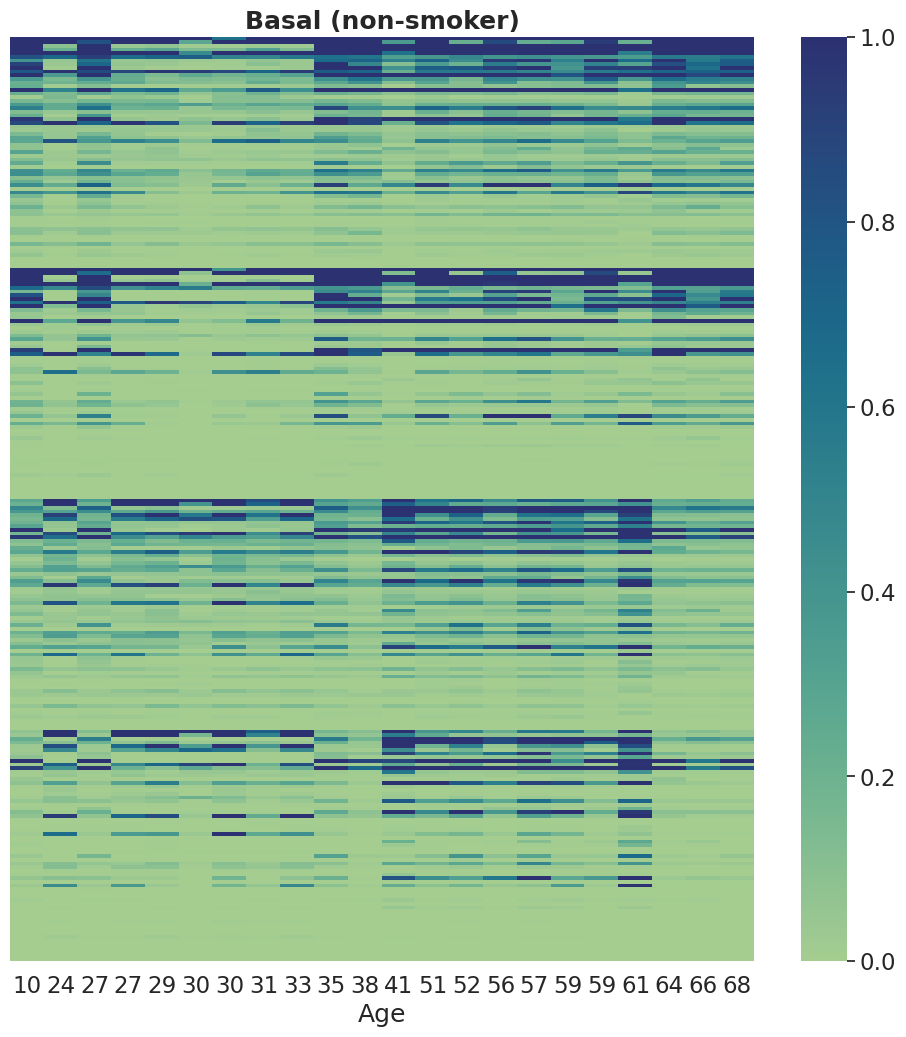

In [31]:
sns.set(font_scale = 1.5)
fig,ax = plt.subplots(figsize = (12,12))
sns.heatmap(plot_data_union["Basal"], ax=ax, vmin=0, vmax=1, cmap="crest", yticklabels = False)
ax.set_title("Basal (non-smoker)", fontdict={"weight":"bold"})
ax.set_xlabel("Age")

if not os.path.isdir("results/figs"):
    os.mkdir("results/figs")
fig.savefig("results/figs/polyHeatmap_figs5_4.svg")

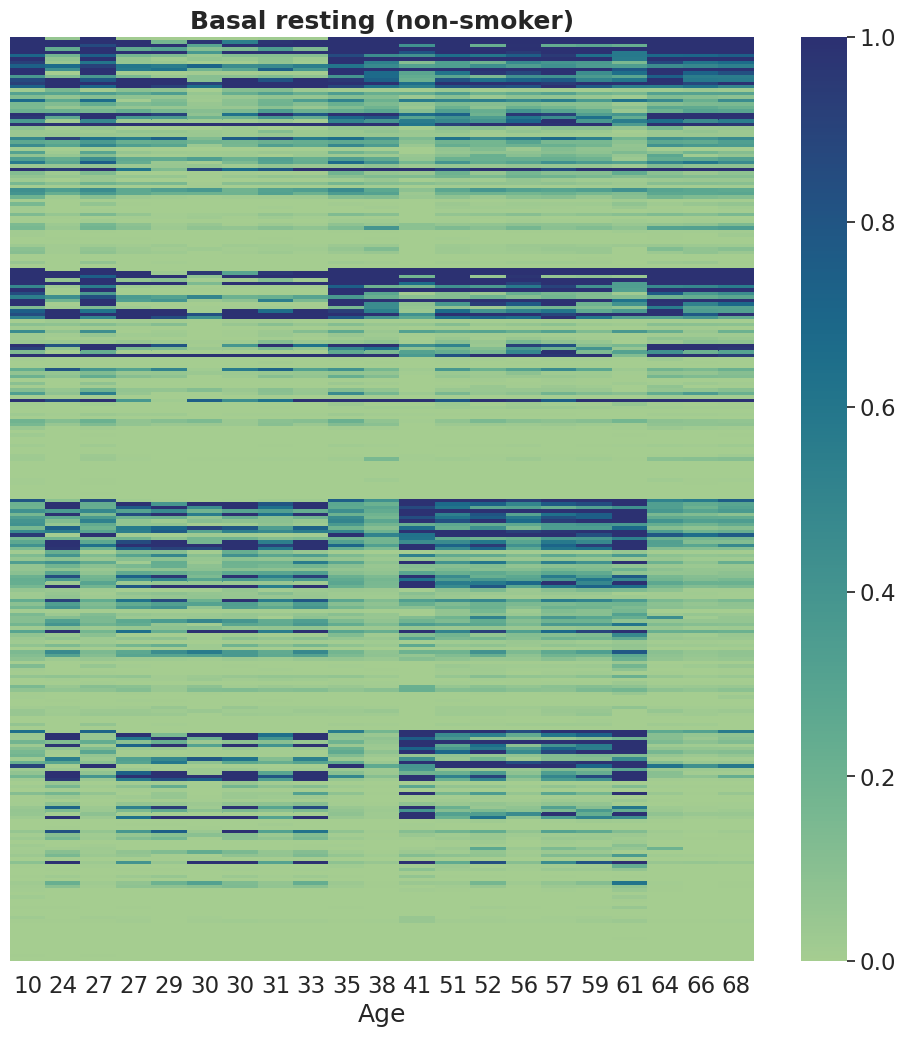

In [32]:
sns.set(font_scale = 1.5)
fig,ax = plt.subplots(figsize = (12,12))
sns.heatmap(plot_data_union["Basal resting"], ax=ax, vmin=0, vmax=1, cmap="crest", yticklabels = False)
ax.set_title("Basal resting (non-smoker)", fontdict={"weight":"bold"})
ax.set_xlabel("Age")

if not os.path.isdir("results/figs"):
    os.mkdir("results/figs")
fig.savefig("results/figs/polyHeatmap_figs5_5.svg")

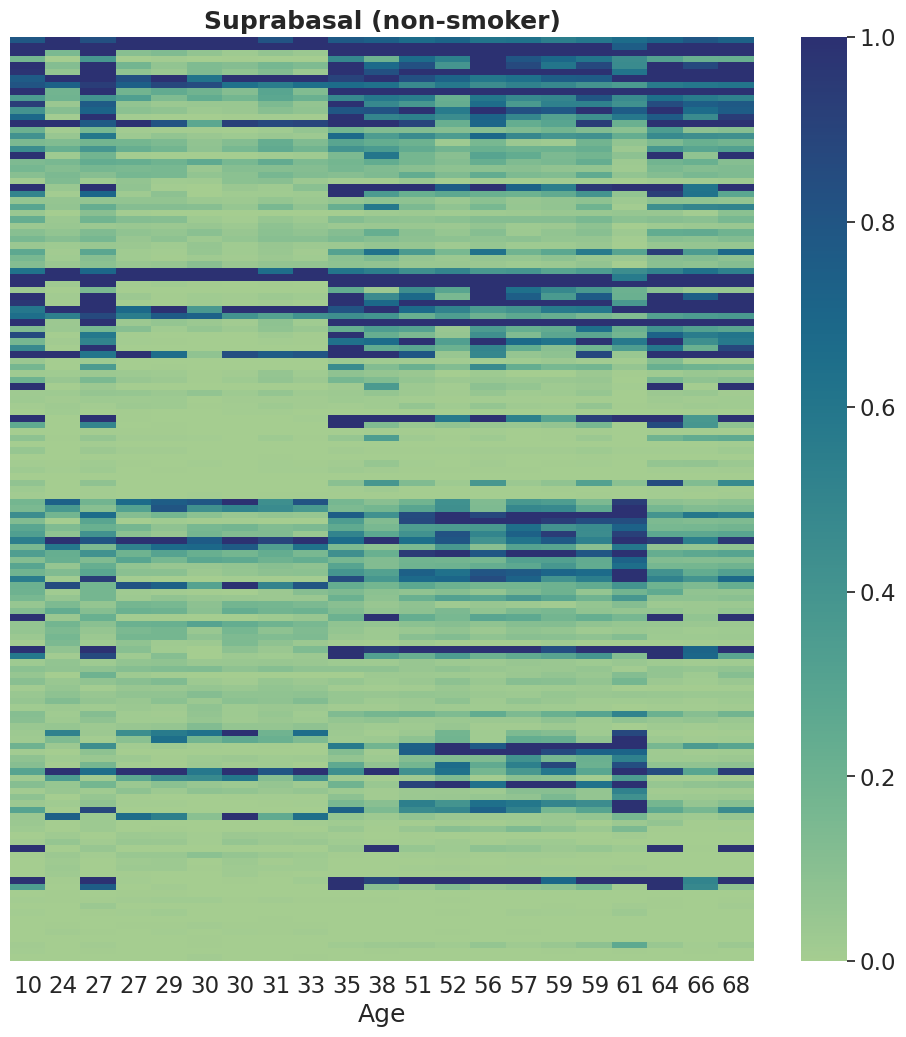

In [33]:
sns.set(font_scale = 1.5)
fig,ax = plt.subplots(figsize = (12,12))
sns.heatmap(plot_data_union["Suprabasal"], ax=ax, vmin=0, vmax=1, cmap="crest", yticklabels = False)
ax.set_title("Suprabasal (non-smoker)", fontdict={"weight":"bold"})
ax.set_xlabel("Age")

if not os.path.isdir("results/figs"):
    os.mkdir("results/figs")
fig.savefig("results/figs/polyHeatmap_figs5_6.svg")